#**Лабораторная работа №3: Классификация и Кластеризация банковских данных**
## **0. Описание задачи**

**Цель:**


1.   Построить модель классификации для предсказания оформления депозита (как в предыдущей версии).
2.   Новое: Провести кластеризацию клиентов банка без использования целевой метки (unsupervised learning) и проверить, насколько найденные кластеры соответствуют реальному разделению на тех, кто взял депозит, и тех, кто нет.


Методы кластеризации: KMeans, DBSCAN, Agglomerative Clustering.
Визуализация: PCA (2 компоненты).

## **1. Импорт библиотек и настройка**

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

seed = 73

## **2. Загрузка и подготовка данных**

Загружаем датасет и сразу отделяем целевую переменную.В задаче кластеризации мы не используем целевую переменную deposit для обучения алгоритмов. Мы отделим её и будем использовать только на этапе финальной оценки (сравнения полученных кластеров с реальностью).
  

1.   Отделяем признаки (X) и целевую метку (y).
2.   Преобразуем целевую метку в числа (0 и 1) для удобства сравнения.
3.   Создаем пайплайн предобработки данных (Encoding + Scaling), так как алгоритмы кластеризации основаны на расстояниях.

In [9]:
url = 'https://raw.githubusercontent.com/Lepsps/ML_homeworks/refs/heads/main/second_hm/dataset/bank.csv'

try:
    df = pd.read_csv(url)
    print("Датасет успешно загружен.")
    print(f"Размерность: {df.shape}")
    display(df.head())
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")

Датасет успешно загружен.
Размерность: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [10]:
# разделение на признаки и целевую переменную
X = df.drop('deposit', axis=1)
y_raw = df['deposit']

le = LabelEncoder()
y_true = le.fit_transform(y_raw)

print("Классы в y_true:", le.classes_)

# определение типов признаков
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# создаем трансформер данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# применяем предобработку ко всему набору данных X
X_processed = preprocessor.fit_transform(X)

print(f"Размерность данных после OneHotEncoding и Scaling: {X_processed.shape}")

Классы в y_true: ['no' 'yes']
Размерность данных после OneHotEncoding и Scaling: (11162, 51)


## **3. Понижение размерности (PCA)**

Данные имеют высокую размерность (после OneHotEncoding). Для визуализации кластеров на плоскости мы используем метод главных компонент (PCA), сжав данные до 2-х измерений.

In [11]:
# применяем PCA
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X_processed)

print(f"Объясненная дисперсия первыми двумя компонентами: {pca.explained_variance_ratio_.sum():.2%}")

# создадем DataFrame для удобства построения графиков
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['True_Label'] = y_raw

Объясненная дисперсия первыми двумя компонентами: 26.18%


### **Визуализация истинного распределения классов**

Посмотрим, как выглядят данные в пространстве PCA, раскрашенные по истинным меткам (yes/no). Это наш эталон ("Ground Truth").

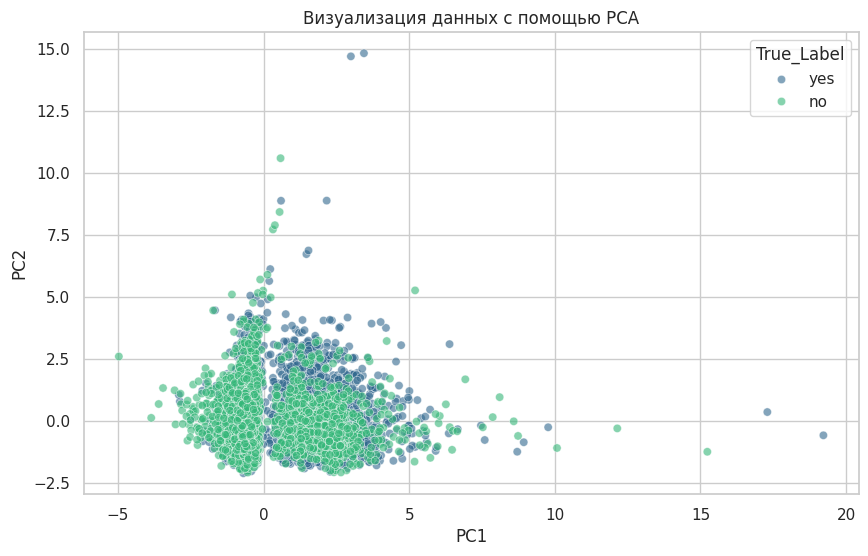

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='True_Label', data=df_pca, palette='viridis', alpha=0.6)
plt.title('Визуализация данных с помощью PCA')
plt.show()

## **4. Кластеризация**

Мы применим 3 алгоритма:


1.   K-Means (Метод k-средних)
2.   DBSCAN (Плотнностный алгоритм)
3.   Agglomerative Clustering (Иерархическая кластеризация)


Для сравнения с истинными метками (где всего 2 класса: yes/no), мы будем пробовать разбивать данные на 2 кластера (кроме DBSCAN, где число кластеров определяется автоматически).

### **Вспомогательная функция для оценки и визуализации:**

In [19]:
def evaluate_and_plot(model_name, labels, true_labels, X_pca_data):
    # вычисление метрик
    ari = adjusted_rand_score(true_labels, labels)
    homogeneity = homogeneity_score(true_labels, labels)
    completeness = completeness_score(true_labels, labels)
    v_measure = v_measure_score(true_labels, labels)

    print(f"--- {model_name} ---")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-Measure: {v_measure:.4f}")

    # визуализация
    plt.figure(figsize=(8, 5))
    unique_labels = np.unique(labels)
    sns.scatterplot(x=X_pca_data[:, 0], y=X_pca_data[:, 1], hue=labels, palette='tab10', legend='full', alpha=0.6)
    plt.title(f'Результат кластеризации: {model_name}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    plt.show()

    return {'Model': model_name, 'ARI': ari, 'V-Measure': v_measure}

results = []

### **Метод 1: K-Means**

Попробуем разбить данные на 2 кластера (так как мы знаем, что в оригинале 2 класса: да/нет). Затем сравним полученные метки с истинными с помощью метрики ARI (Adjusted Rand Index).


*   ARI = 1.0 — идеальное совпадение.
*   ARI = 0.0 — случайное совпадение.    

--- K-Means (k=2) ---
Adjusted Rand Index (ARI): 0.0473
Homogeneity: 0.0368
Completeness: 0.0458
V-Measure: 0.0408


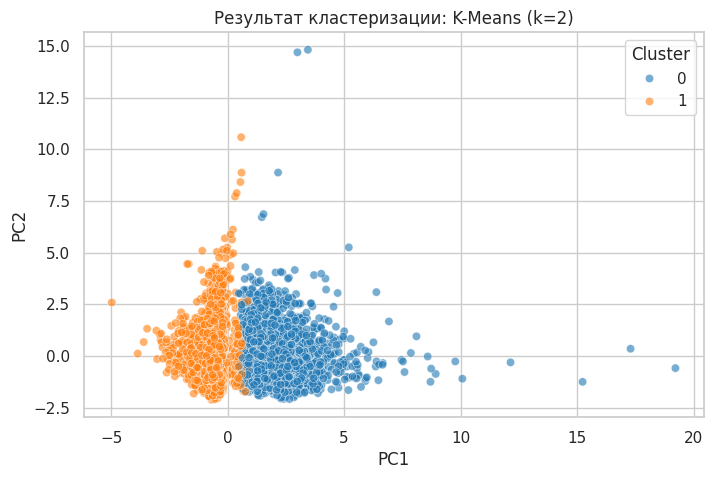

In [20]:
kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)

res_kmeans = evaluate_and_plot("K-Means (k=2)", kmeans_labels, y_true, X_pca)
results.append(res_kmeans)

### **Метод 2: DBSCAN**

DBSCAN сам определяет количество кластеров на основе плотности точек.


*   eps: радиус окрестности.
*   min_samples: минимальное количество точек, чтобы считать область плотной.

Поскольку данные имеют высокую размерность, DBSCAN может работать сложно. Метка -1 означает "шум" (выбросы).

DBSCAN нашел кластеров: 1
Точек, помеченных как шум: 720
--- DBSCAN ---
Adjusted Rand Index (ARI): 0.0057
Homogeneity: 0.0056
Completeness: 0.0161
V-Measure: 0.0083


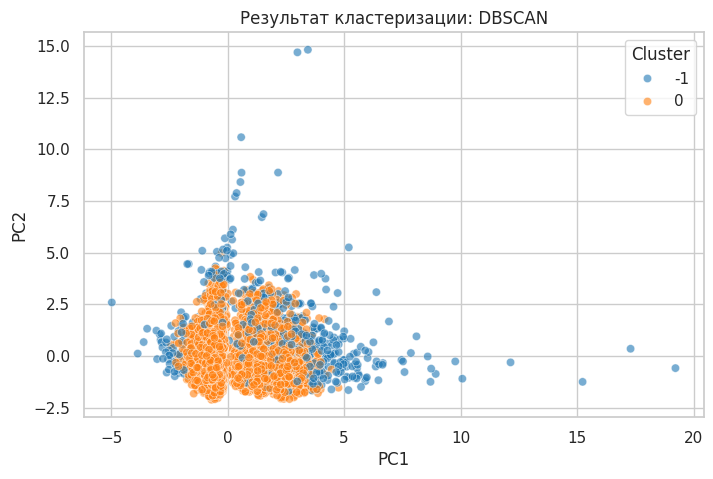

In [21]:
dbscan = DBSCAN(eps=2.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_processed)

n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print(f"DBSCAN нашел кластеров: {n_clusters_}")
print(f"Точек, помеченных как шум: {n_noise_}")

res_dbscan = evaluate_and_plot("DBSCAN", dbscan_labels, y_true, X_pca)
results.append(res_dbscan)

### **Метод 3: Agglomerative Clustering (Иерархическая)**

Этот метод строит дерево кластеров, объединяя ближайшие точки. Мы принудительно разобъем дерево на 2 кластера.


--- Agglomerative Clustering ---
Adjusted Rand Index (ARI): 0.0283
Homogeneity: 0.0217
Completeness: 0.0289
V-Measure: 0.0248


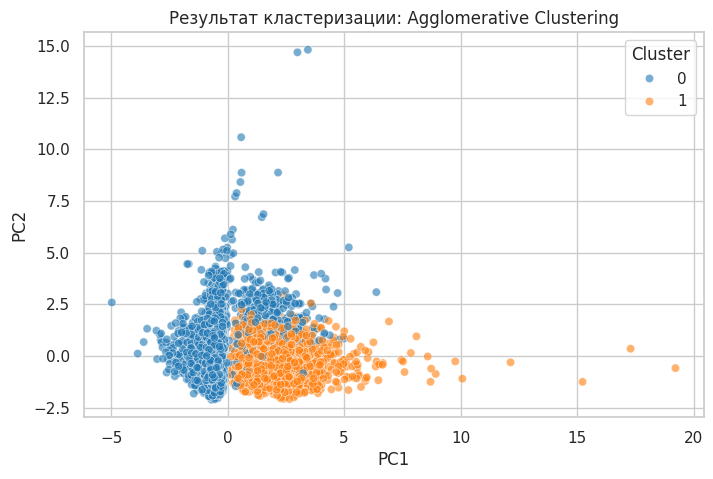

In [22]:
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X_processed)

res_agglo = evaluate_and_plot("Agglomerative Clustering", agglo_labels, y_true, X_pca)
results.append(res_agglo)

## **5. Итоговое сравнение и выводы**

Сравним метрики качества кластеризации относительно истинных меток.


*   ARI (Adjusted Rand Index): от -1 до 1. 1 = идеальное совпадение с истинными метками, 0 = случайное угадывание.
*   V-Measure: среднее гармоническое между однородностью и полнотой

In [23]:
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='ARI', ascending=False))

,Model,ARI,V-Measure
0,K-Means (k=2),0.047272,0.040814
2,Agglomerative Clustering,0.028346,0.024770
1,DBSCAN,0.005749,0.008285


### **Выводы**


1.   **Природа данных**: Визуализация PCA показывает, что классы yes и no в исходных данных сильно пересекаются в пространстве признаков. Четкой геометрической границы или явных отдельных "сгустков" (кластеров), соответствующих классам депозитов, нет.
2.   **K-Means** и **Agglomerative Clustering**: Эти алгоритмы принудительно разделили данные на 2 части. Однако, судя по низкому значению ARI (близкому к 0), полученные кластеры не совпадают с логикой "взял депозит / не взял". Вероятно, алгоритмы сгруппировали людей по другим признакам (например, "молодые и бедные" vs "пожилые и богатые"), которые геометрически более выражены, чем целевое действие.
3.   **DBSCAN**: Этот алгоритм выделил один крупный кластер и пометил множество точек как шум (или нашел несколько мелких групп). Это подтверждает гипотезу о том, что данные достаточно плотные и однородные, и в них нет явной структуры плотности, которая бы коррелировала с целевой переменной `deposit`.





**Общий итог:** Задача предсказания депозита плохо решается методами обучения без учителя (кластеризацией) "в лоб". Признаки, определяющие согласие клиента, сложны и не формируют явных геометрических кластеров в исходном пространстве. Для этой задачи методы обучения с учителем (Random Forest, Boosting), использованные в предыдущей версии работы, подходят гораздо лучше.